Version July 2024
# This notebook contains:
* Functions to open barra-2, him-8 and BoM AURA radar datasets (stored on gadi.nci)
* Plotting the zonal 850hPa winds, ch.13BT and radar reflectivity data

In [1]:
# import libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
import dask.array as da
import dask.dataframe as dd
import dask.bag as db
import dask.distributed

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Functions to open/mask data

In [92]:
def open_barra2(variable: str,months: list) -> None:
    """Function to create a list of BARRA-2 filepaths and open the dataset for a given variable.
    
    Args:
        variable (str): The variable name. The BARRA-2 list of variable names can be found at http://www.bom.gov.au/research/publications/researchreports/BRR-067.pdf (Chun-Hsu Su et al., 2022).
        months (list): list of each month of data required. Format for each month is yyyymm-yyyymm (str) e.g. ["202201-202201"] for January 2022.
    
    Returns:
        ds: BARRA-2 dataset for the given months of given variable.
    """
    months.sort()
    file_paths = []
    for i in months:
        fp = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/"+variable+"/v20240516/"   # version periodically updates to new year/month
        all_files = [fp+variable+"_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    ds = xr.open_mfdataset(file_paths)
    return ds 

def open_him8(directory: str,file_name: str) -> None:
    """Function to create a list of file paths and open the regridded satellite dataset.

    Args:
        directory (str): Directory file path as a string.
        file_name (str): Beginning of file name as a string.

    Returns:
        ds: Dataset
    """
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.startswith(file_name):  
                file_paths.append(os.path.join(root, file))
    ds = xr.open_mfdataset(file_paths)
    return ds

def open_radar(months: list,file_path: str,radar_site_no: str,open_ds: bool=False) -> None:
    """Function to create a list of file paths and open the radar variable datasets.

    Args:
        months (list): List of strings. Each string represents a month to open data e.g. "202112" for data from December 2021. 
        file_path (str): File path as a string for where data is stored in project rq0. Variables used are found at: "level_2/73/REFLECTIVITY" and "admin/level_2_decomissioned_fields/73/RAINRATE". 
        radar_site_no (str): Radar site number (BoM ID) as a string --> Townsville is "73". open_ds (bool): If True, opens the datasets and returns the combined dataset. If False, returns the list of file paths.

    Returns:
        Union[xarray.Dataset, list]: The combined dataset if open_ds is True, otherwise the list of file paths.
    """
    file_list = []
    for i in months:
        fp = "/g/data/rq0/"+file_path+"/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i)]
        file_list.extend(all_files)
    file_list.sort()
    if open_ds:
        ds = xr.open_mfdataset(file_list)
        return ds
    else:
        return file_list

def radar_mask(file_path: str,threshold: float,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'}) -> None:
    """Function to mask radar data using the climatological rain rate (points where climatolical rain rate is below a threshold are masked -> i.e. regions where ground clutter and beam blockage affect retrievals).

    Args:
        file_path (str): The file paths to the radar rainrate dataset to be opened and used in creating the mask.
        threshold (float): A lower rain rate threshold to mask non-real values below a certain rain rate.
        chunks (dict): Chunking pattern for xarray to handle large datasets. Default is {'time': 'auto', 'x': 'auto', 'y': 'auto'}.

    Returns:
        xr.Dataset: Radar dataset masking a given latitudinal range and regions affected by beam blockage (ds has x,y coordinates).
    """
    with xr.open_mfdataset(file_path, engine="netcdf4",combine='by_coords', chunks=chunks, parallel=True) as ds:
        # The polygon is used to choose the latitudinal band between -18.5 S and -20.5 S, points at other latitudes are masked
        polygon = Polygon([
                    (-150000, 125000),
                    (-150000, -50000),
                    (150000, -50000),
                    (150000, 125000),
                ])
        gdf = gpd.GeoDataFrame({'geometry': [polygon]})

        # Mask points outside the latitudinal band (polygon)
        file = xr.open_dataset(file_path[0], engine="netcdf4") 
        mask_lat = regionmask.mask_geopandas(gdf, file.x, file.y, wrap_lon=False) 
        mask1 = mask_lat.where(~mask_lat.isnull()).astype(bool)
        # Change mask so that: true==within latitude band, false==otherwise
        mask1_flip = ~mask1 

        # Compute the mean rain rate and apply the secondary mask for beam blockage (by using a lower threshold)
        mean_rr = ds.rainrate.mean(dim="time")
        mask2 = xr.where((mean_rr < threshold), 0,1).astype(bool)
        
        # Masks are combined using the logical &
        mask = mask1_flip & mask2
    return mask

# Plotting functions

In [88]:
def plot_panel(ax: plt.Axes,lon: np.ndarray,time,values: np.ndarray,levels: np.ndarray,cmap: str,cbar_label: str,fontsize: int,title: str,xaxis_label: str,
               yaxis_label: str=None,yticklabels: bool=True) -> None:
    """Helper function to plot a single panel.
    
    Args:
        ax (plt.Axes): Matplotlib axis to plot on.
        lon (np.ndarray): Array of longitude values.
        time (np.ndarray): Array of time values.
        values (xr.DataArray): Data array of values to plot.
        levels (np.ndarray): Contour levels for the plot.
        cmap (str): Colormap for the plot.
        cbar_label (str): Label for the colorbar.
        title (str): Title for the plot.
        xaxis_label (str): Label for the x-axis.
        yaxis_label (str, optional): Label for the y-axis. Defaults to None.
        yticklabels (bool, optional): Whether to show y-axis tick labels. Defaults to True.
    """
    cf = ax.contourf(lon,time,values,levels=levels,cmap=cmap)
    cbar = plt.colorbar(cf,ax=ax,orientation="horizontal",pad=0.1)
    cbar.set_label(label=cbar_label,fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xaxis_label,fontsize=fontsize)
    if yaxis_label:
        ax.set_ylabel(yaxis_label,fontsize=fontsize)
    if not yticklabels:
        ax.set_yticklabels([])

def plot_figure(fig_title: str, barra_params: dict, h8_params: dict, ref_params: dict, axes_params: dict) -> None:
    """Function to plot a 3-panel Hovmöller figure for each variable for DJF 2021-2022.

    Args:
        fig_title (str): Figure title
        barra_params (dict): Parameters for BARRA plot
        h8_params (dict): Parameters for H8 plot
        ref_params (dict): Parameters for Reflectivity plot
        axes_params (dict): Parameters for axes and boxes
    """
    fig, ax = plt.subplots(1, 3, figsize=[12, 12])  # [width, height] in inches
    fig.suptitle(fig_title, fontsize=20, bbox={'facecolor': 'white', 'alpha': 0, 'pad': 0.01})
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    plot_panel(ax[0], **barra_params, xaxis_label=axes_params['xaxis_label'], yaxis_label=axes_params['yaxis_label'])
    plot_panel(ax[1], **h8_params, xaxis_label=axes_params['xaxis_label'], yticklabels=False)
    plot_panel(ax[2], **ref_params, xaxis_label=axes_params['xaxis_label'], yticklabels=False)

    for a in ax: 
        for line in axes_params['radar_site_vertical_line']:
            a.axvline(line['position'], color=line['color'], alpha=0.7, linestyle=line.get('linestyle', '-'))
    
    for a in ax[0],ax[1]:
        for line in axes_params['vertical_lines']:
            a.axvline(line['position'], color=line['color'], alpha=0.7, linestyle=line.get('linestyle', '-'))

    for box in axes_params['boxes']:
        ax[0].axhline(box['bottom'], color='black', alpha=0.7)
        ax[0].axhline(box['top'], color='black', alpha=0.7)

    return

# Results

In [72]:
# Open BARRA-2 and H8 datasets (change strings for directory where files are stored/months required)
barra = open_barra2("ua850",["202201-202201","202202-202202","202112-202112"]) # list files for variable ua850 (zonal winds at 850 hPa).
h8 = open_him8("/home/563/ac9768/himawari_regridded_files","case-study_ch13BT_00UTC-01")
# Take a slice of the H8 dataset so nov and mar are not plotted
h8_slice = h8.sel(time=slice('2021-12-01T00:00:00.000000000','2022-02-28T23:00:00.000000000'))

In [4]:
# Open radar reflectivity + rain rate dataset for DJF
towns_ref = open_radar(["202112","202201","202202"],"level_2/73/REFLECTIVITY","73",open_ds=True)
towns_rr = open_radar(["202112","202201","202202"],"admin/level_2_decomissioned_fields/73/RAINRATE","73",open_ds=True)
# Open_ds set to false for creating the radar (rain rate) mask -> otherwise number of files opened in memory is very large 
towns_rr_files = open_radar(["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204"],
           "admin/level_2_decomissioned_fields/73/RAINRATE","73",open_ds=False)

In [94]:
# Create the radar mask
radar_mask = radar_mask(towns_rr_files,1) #0.8
# radar_mask.plot() # to see which regions are masked
masked_ds = towns_ref.where(radar_mask) 

In [97]:
# create dictionaries for plotting variables
barra_params = {
    'lon': barra.sel(lon=slice(143,152.1)).lon.values,
    'time': barra.time.values,
    'values': barra.ua850.sel(lat=slice(-20.5,-18.5),lon=slice(143,152.1)).mean(dim="lat"),
    'levels': np.arange(-20,22,2),
    'cmap': "bwr",
    'cbar_label': "m/s",
    'fontsize': 15,
    'title': "850 hPa Zonal Wind Speed"
}
h8_params = {
    'lon': h8_slice.sel(lat=-19.4198,method="nearest").isel(time=0).lon.values,
    'time': h8_slice.time.values,
    'values': h8_slice.ch13BT.sel(lat=slice(-20.5,-18.5)).mean(dim="lat"),
    'levels': np.arange(190,330,10),
    'cmap': "binary",
    'cbar_label': 'Ch.13 BT (°K)',
    'fontsize': 15,
    'title': "Ch.13 Brightness Temperature"
}
ref_params = {
    'lon': towns_ref.isel(time=0,y=150).longitude.values,
    'time': towns_ref.time.values,
    # 'values': towns_ref.reflectivity.mean(dim="y"),
    'values': masked_ds.reflectivity.mean(dim="y"),
    'levels': [5,10,15,20,25,30,35,40],
    'cmap': "jet",
    'cbar_label': 'dBZ',
    'fontsize': 15,
    'title': "Radar Reflectivity"
}
axes_params = {
    'xaxis_label': 'Longitude (°E)',
    'yaxis_label': 'Time (UTC)',
    'radar_site_vertical_line': [
        {'position': 146.5509, 'color': 'red', 'linestyle': '--'}
    ],
    'vertical_lines': [
        {'position': 147.5, 'color': 'royalblue', 'linestyle': '--'},
        {'position': 145.12054, 'color': 'black'},
        {'position': 147.9812, 'color': 'black'}
    ],
    'boxes': [
        {'bottom': towns_ref.sel(time="2021-12-26T00:00:00.000000000").time.values, 'top': towns_ref.sel(time="2021-12-27T00:00:00.000000000").time.values},
        {'bottom': towns_ref.sel(time="2022-01-23T00:00:00.000000000").time.values, 'top': towns_ref.sel(time="2022-01-24T00:00:00.000000000").time.values}
    ]
}

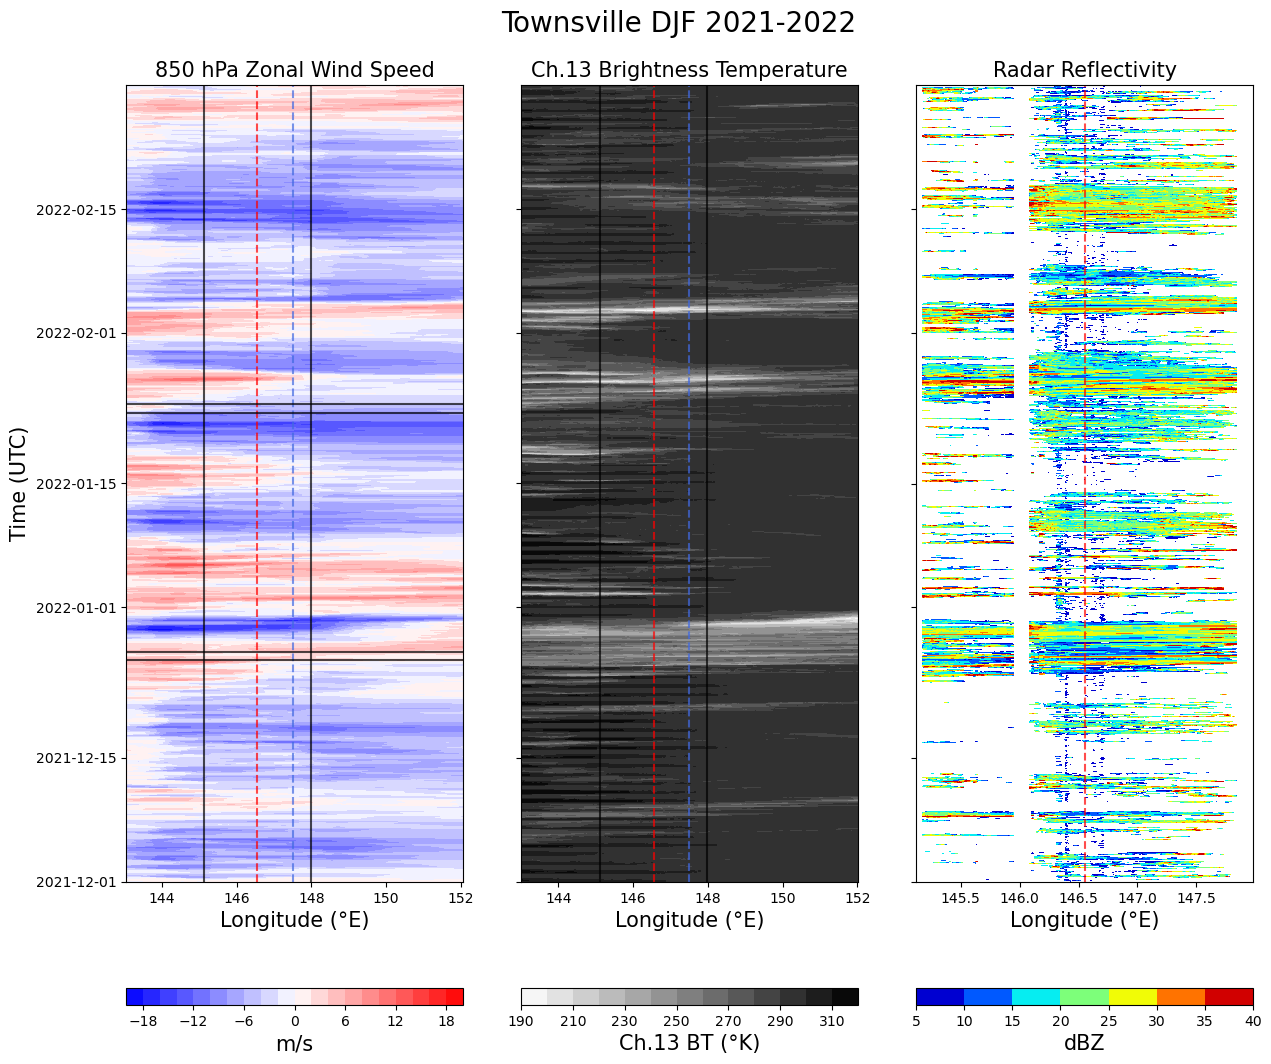

In [98]:
plot_figure('Townsville DJF 2021-2022', barra_params, h8_params, ref_params, axes_params) 

# Plotting (without using function)

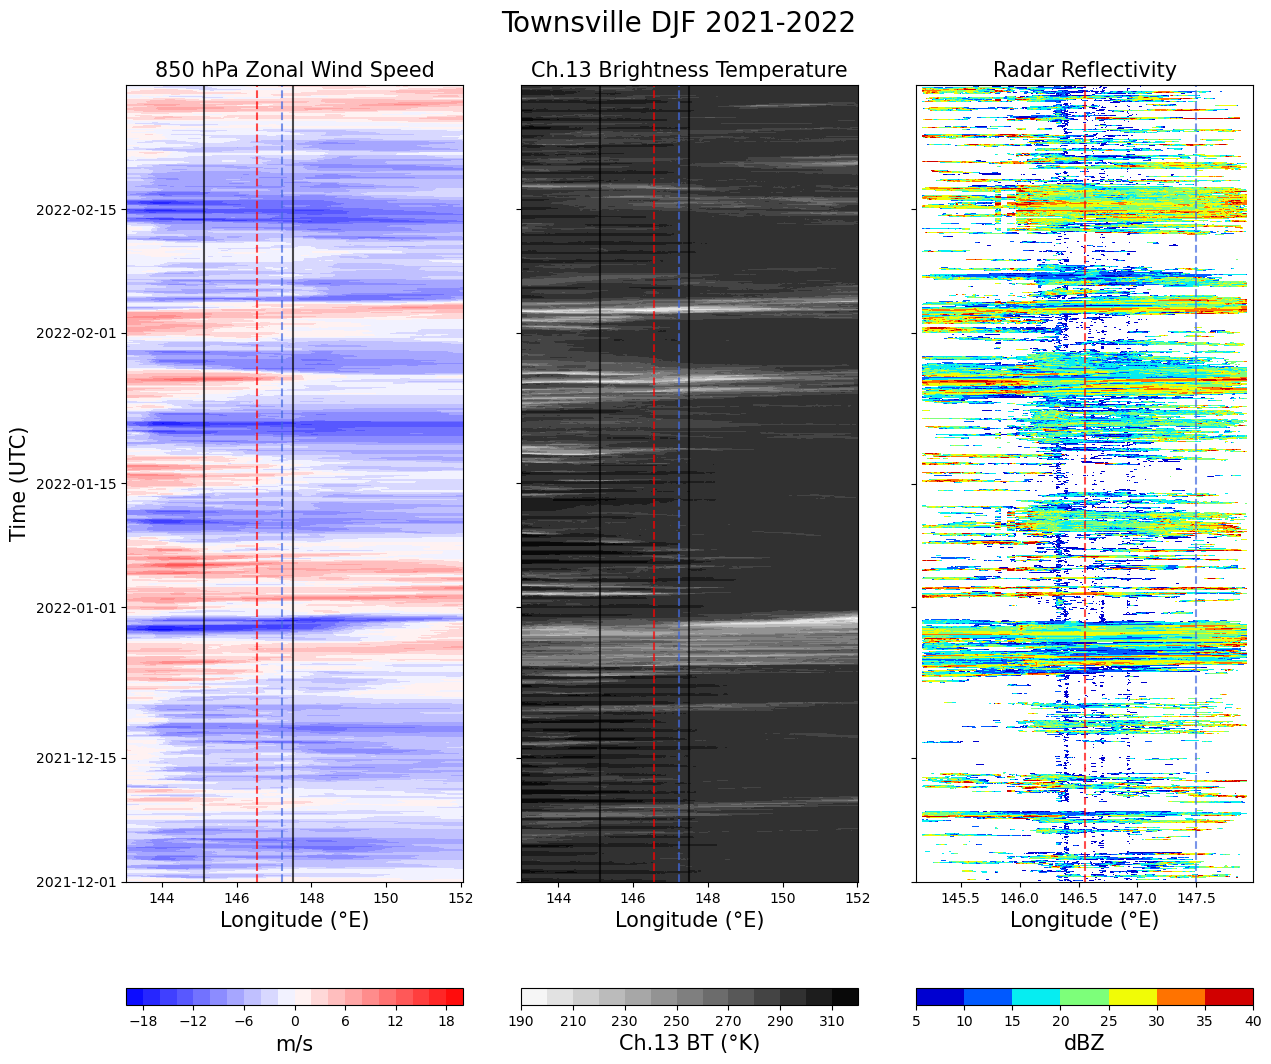

In [74]:
fig,ax = plt.subplots(1,3,figsize=[12,12]) # [width,height] in inches
fig.suptitle("Townsville DJF 2021-2022",fontsize=20,bbox={'facecolor': 'white', 'alpha': 0, 'pad': 0.01})
fig.tight_layout(rect=[0, 0, 1, 0.97])

# plot zonal 850hPa winds
barra_slice = barra.sel(lon=slice(143,152.1))
lon_barra = barra_slice.lon.values
time_barra = barra.time.values
values_barra = barra_slice.ua850.sel(lat=slice(-20.5,-18.5)).mean(dim="lat")
levels_barra = np.arange(-20,22,2)
cf_barra = ax[0].contourf(lon_barra,time_barra,values_barra,levels=levels_barra,cmap="bwr")#"PuOr")
cbar_barra = fig.colorbar(cf_barra, ax=ax[0], orientation='horizontal', pad=0.1)
cbar_barra.set_label(label='m/s',fontsize=15)
ax[0].axvline(146.5509,color='red',alpha=0.7,linestyle='--')
ax[0].axvline(147.21666,color='royalblue',alpha=0.7,linestyle='--')
ax[0].set_ylabel("Time (UTC)",fontsize=15)
ax[0].set_xlabel("Longitude (°E)",fontsize=15)
ax[0].set_title("850 hPa Zonal Wind Speed",fontsize=15)
ax[0].axvline(145.12054,color='black',alpha=0.7)
ax[0].axvline(147.5,color='black',alpha=0.7) #147.9812

# plot ch13bt
lon = h8.sel(lat=-19.4198,method="nearest").isel(time=0).lon.values
time = h8_slice.time.values
values = h8_slice.ch13BT.sel(lat=slice(-20.5,-18.5)).mean(dim="lat") #-19.4198,method="nearest")  #lat=slice(-20.5,-18.5)
levels = np.arange(190,330,10)
cf = ax[1].contourf(lon,time,values,levels=levels,cmap="binary")
cbar = fig.colorbar(cf, ax=ax[1], orientation='horizontal', pad=0.1)
cbar.set_label(label='Ch.13 BT (°K)',fontsize=15)
ax[1].axvline(146.5509,color='red',alpha=0.7,linestyle='--')
ax[1].axvline(147.21666,color='royalblue',alpha=0.7,linestyle='--')
ax[1].set_yticklabels([])
ax[1].set_xlabel("Longitude (°E)",fontsize=15)
ax[1].set_title("Ch.13 Brightness Temperature",fontsize=15)
ax[1].axvline(145.12054,color='black',alpha=0.7)
ax[1].axvline(147.5,color='black',alpha=0.7)

# plot reflectivity
# towns_ds = xr.open_mfdataset(towns_ref)
towns_longitude_values = towns_ref.isel(time=0,y=150).longitude.values
time_ref = towns_ref.time.values
values_ref = masked_ds.reflectivity.mean(dim="y") 
levels_ref = np.arange(0,40,5)
levels_ref = [5,10,15,20,25,30,35,40]
cf_ref = ax[2].contourf(towns_longitude_values,time_ref,values_ref,levels=levels_ref,cmap="jet")
cbar_ref = fig.colorbar(cf_ref, ax=ax[2], orientation='horizontal', pad=0.1)
cbar_ref.set_label(label='dBZ',fontsize=15)
ax[2].axvline(146.5509,color='red',alpha=0.7,linestyle='--')
# ax[2].axvline(147.5,color='royalblue',alpha=0.7,linestyle='--')
ax[2].set_yticklabels([])
ax[2].set_xlabel("Longitude (°E)",fontsize=15)
ax[2].set_title("Radar Reflectivity",fontsize=15);